<a href="https://colab.research.google.com/github/2667schummr/recurrent-nn-cystic-fibrosis/blob/master/cf_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from google.colab import drive, files
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
# Specify training parameters
device = '/device:GPU:0'
print_every = 100
batch_size = 100

In [0]:
# Make google drive files accessible and import utils module
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Colab Notebooks/notebook1-reduced-data'
os.chdir(path)
print('Current Working Directory: {}'.format(os.getcwd()))
from utils import *

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Current Working Directory: /content/gdrive/My Drive/Colab Notebooks/notebook1-reduced-data


## Data Description  
The dataset used to train this network utilizes observations from the entire time period over which patients were tracked but only those features which have no missing values were included.



In [0]:
# Load the panda dataframe containing the features
feats = pd.read_pickle('../cf-data/processed_data_complete_feats.pkl')
print('Feature Shape: {}'.format(feats.shape))

num_feats = feats.shape[1] - 2
max_seq_length = feats.groupby('eDWID').count()['YRM'].max()

drop_cols = ['eDWID', 'YRM'] # These are identification columns
feats.head()

Feature Shape: (513452, 34)


,eDWID,YRM,mssa,mrsa,h_flu,pseudo,burkho_complex,alcalig,steno,enterobacter,serratia_marcescens,aspergillus,candida,scedosporium,mabscessus,mai,bd_age,sex,suff,trunc03,all_tob,all_mod,all_bd,dnase,inhcolistin,inhaztreonam,hypersaline,chronic_macrolide,oral_steroids,inh_steroids,inhsteroids_bronchodil,oral_other_abx,txflag,othertx
0,900000702,2003,0,0,0,1,0,0,0,0,0,1,0,0,0,0,6,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0
1,900000702,2004,0,0,0,1,0,0,0,0,0,0,0,0,0,0,7,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
2,900000702,2005,0,0,0,1,0,0,0,0,0,1,0,0,0,0,8,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0
3,900000702,2006,0,0,0,1,0,0,0,0,0,1,0,0,0,0,9,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0
4,900000702,2007,0,0,0,1,0,0,0,0,0,1,0,0,0,0,10,0,0,0,1,0,1,1,0,0,0,1,0,1,0,0,0,0


In [0]:
# Load the pandas dataframe containing the labels
labels = pd.read_pickle('../cf-data/dflags.pkl')
print('Labels Shape: {}'.format(labels.shape))
num_obs = labels.shape[0]
labels.head()

Labels Shape: (43454, 2)


,eDWID,dflag
0,900000702,0
99,900000736,0
106,900000742,1
196,900000776,0
200,900010702,1


## Oversampling  
The original attempts to train the networks failed because the networks would learn to predict 0 for every observation.  About 73% of the data has a 0-label so the accuracy was high but the true positive rate was nearly 0.  To correct this problem, the observations in the training data with labels of 1 were selected at random more than once such that the resulting training data had 50% of its observations as class 1.  The data used to test the network was unaltered.  

In [0]:
# Split the data into training and testing sets and create Dataset objects 
# and oversample training data for class balance
labels = labels.sample(frac=1)
labels_train, labels_test = train_test_split(labels, test_size=0.2, shuffle=False)

ros = RandomOverSampler()
X, y = ros.fit_resample(labels_train['eDWID'].as_matrix().reshape((-1, 1)), 
                        labels_train['dflag'])
labels_train = pd.DataFrame({'eDWID': X.reshape((-1,)), 'dflag': y})

patient_batches_train = Dataset(labels_train, batch_size, shuffle=True)
patient_batches_test = Dataset(labels_test, batch_size, shuffle=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/content/gdrive/My Drive/Colab Notebooks/notebook1-reduced-data/utils.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.X = labels['eDWID'].as_matrix()
/content/gdrive/My Drive/Colab Notebooks/notebook1-reduced-data/utils.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.y = labels['dflag'].as_matrix()


Means Deaths per Batch 0.49964497041420125


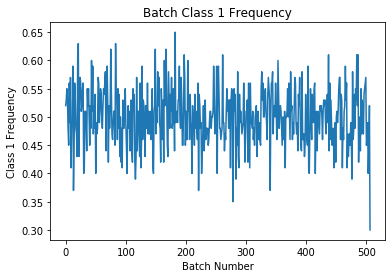

In [0]:
# Compute the 1-class frequency for the training data batches
deaths_per_batch = []
batch_num = []
for i, (patients, patient_labels) in enumerate(patient_batches_train):
  deaths_per_batch.append(patient_labels.sum() / patient_labels.shape[0])
  batch_num.append(i)

plt.figure()
plt.plot(batch_num, deaths_per_batch);
plt.title('Batch Class 1 Frequency')
plt.xlabel('Batch Number')
plt.ylabel('Class 1 Frequency')

mean_deaths_per_batch = np.array(deaths_per_batch).mean()
print('Means Deaths per Batch {}'.format(mean_deaths_per_batch))

In [0]:
one_class_freq_train = labels_train['dflag'].mean()
one_class_freq_test = labels_test['dflag'].mean()
print('1 Class Frequency for Training: {}'.format(one_class_freq_train))
print('1 Class Frequency for Test: {}'.format(one_class_freq_test))

1 Class Frequency for Training: 0.5
1 Class Frequency for Test: 0.27522724657691866


## Simple RNN Network Architecture  
The purpose of this network is to see if a RNN can learn effectively on this dataset.  The network consists of a single vanilla RNN layer with two outputs corresponding to the class scores.  

In [0]:
def model_init_fn(inputs, is_training, seq_filter):
    model = tf.keras.Sequential()
    model.add(
        tf.keras.layers.SimpleRNN(2, 
                                  batch_input_shape=(None, max_seq_length, num_feats),
                                  return_sequences=False))
    return model(inputs, mask=seq_filter, training=is_training) 

learning_rate = 1e-3
def optimizer_init_fn():
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    return optimizer

loss_history_rnn, perf_history_rnn = train(model_init_fn, optimizer_init_fn, 
                                          max_seq_length, num_feats, patient_batches_train, 
                                          patient_batches_test, batch_size, feats, 
                                          drop_cols, labels, print_every, num_epochs=1)

Starting epoch 0


/content/gdrive/My Drive/Colab Notebooks/notebook1-reduced-data/utils.py:36: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  patient_feats = patient_feats.as_matrix()
/content/gdrive/My Drive/Colab Notebooks/notebook1-reduced-data/utils.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  Y[i] = labels[labels.eDWID == patient]['dflag'].as_matrix()[0]


Iteration 0, loss = 0.9719
Accuracy: Got 6297 / 8700 correct (72.38%)
Precision: Got 1 / 2392.0 correct (0.04180602006688963%)
True Negative Rate: Got 6296 / 6308.0 correct (99.80976537729866%)

Iteration 100, loss = 0.6909
Accuracy: Got 6292 / 8700 correct (72.32%)
Precision: Got 37 / 2392.0 correct (1.5468227424749164%)
True Negative Rate: Got 6255 / 6308.0 correct (99.15979708306912%)

Iteration 200, loss = 0.6124
Accuracy: Got 6585 / 8700 correct (75.69%)
Precision: Got 489 / 2392.0 correct (20.44314381270903%)
True Negative Rate: Got 6096 / 6308.0 correct (96.63918833227648%)

Iteration 300, loss = 0.4549
Accuracy: Got 7131 / 8700 correct (81.97%)
Precision: Got 1932 / 2392.0 correct (80.76923076923077%)
True Negative Rate: Got 5199 / 6308.0 correct (82.41915028535193%)

Iteration 400, loss = 0.3653
Accuracy: Got 7168 / 8700 correct (82.39%)
Precision: Got 2020 / 2392.0 correct (84.44816053511705%)
True Negative Rate: Got 5148 / 6308.0 correct (81.61065313887127%)

Iteration 500, 

## Multi-Layer LSTM Network Architecture  
The next architecture trained consisted of three RNN layers with LSTM cells.  The outputs of the first two layers are sequences of vectors of size 100.  The final RNN layer outputs a single vector of size two corresponding to the class scores.  

In [0]:
def model_init_fn(inputs, is_training, seq_filter):
    layers = [tf.keras.layers.LSTM(100,
                                   batch_input_shape=(None, max_seq_length, num_feats),
                                   return_sequences=True), 
              tf.keras.layers.LSTM(100, return_sequences=True),
              tf.keras.layers.LSTM(2, return_sequences=False)]
    model = tf.keras.Sequential(layers)

    return model(inputs, mask=seq_filter, training=is_training) 

learning_rate = 1e-3
def optimizer_init_fn():
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    return optimizer

loss_history_lstm, perf_history_lstm = train(model_init_fn, optimizer_init_fn, 
                                             max_seq_length, num_feats, patient_batches_train, 
                                             patient_batches_test, batch_size, 
                                             feats, drop_cols, labels, print_every, 
                                             num_epochs=1)

Starting epoch 0


/content/gdrive/My Drive/Colab Notebooks/notebook1-reduced-data/utils.py:36: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  patient_feats = patient_feats.as_matrix()
/content/gdrive/My Drive/Colab Notebooks/notebook1-reduced-data/utils.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  Y[i] = labels[labels.eDWID == patient]['dflag'].as_matrix()[0]


Iteration 0, loss = 0.6913
Accuracy: Got 2401 / 8700 correct (27.60%)
Precision: Got 2392 / 2392.0 correct (100.0%)
True Negative Rate: Got 9 / 6308.0 correct (0.14267596702599875%)

Iteration 100, loss = 0.4887
Accuracy: Got 7440 / 8700 correct (85.52%)
Precision: Got 1955 / 2392.0 correct (81.73076923076923%)
True Negative Rate: Got 5485 / 6308.0 correct (86.95307545973367%)

Iteration 200, loss = 0.3368
Accuracy: Got 7432 / 8700 correct (85.43%)
Precision: Got 2076 / 2392.0 correct (86.78929765886288%)
True Negative Rate: Got 5356 / 6308.0 correct (84.90805326569436%)

Iteration 300, loss = 0.4767
Accuracy: Got 7209 / 8700 correct (82.86%)
Precision: Got 2194 / 2392.0 correct (91.72240802675586%)
True Negative Rate: Got 5015 / 6308.0 correct (79.50221940393152%)

Iteration 400, loss = 0.3520
Accuracy: Got 7485 / 8700 correct (86.03%)
Precision: Got 2104 / 2392.0 correct (87.95986622073578%)
True Negative Rate: Got 5381 / 6308.0 correct (85.30437539632213%)

Iteration 500, loss = 0.4

## Multi-Layer LSTM RNN plus a Fully Connected Network
This architecture consists of two RNN layers with LSTM cells.  The first layer outputs a sequence of vectors of size 500.  The second layer processes the vector sequence and outputs a single vector also of size 500.  This vector is then passed to a fully-connected network with one hidden layer of size 500 with ReLU activations.  The output space of the fully-connected network has a size of 2 corresponding to the class scores. 

In [0]:
def model_init_fn(inputs, is_training, seq_filter):
    layers = [tf.keras.layers.LSTM(500,
                                   batch_input_shape=(None, max_seq_length, num_feats),
                                   return_sequences=True), 
              tf.keras.layers.LSTM(500, return_sequences=False),
              tf.keras.layers.Dense(500, activation='relu'),
              tf.keras.layers.Dense(2)]
    model = tf.keras.Sequential(layers)

    return model(inputs, mask=seq_filter, training=is_training) 

learning_rate = 1e-3
def optimizer_init_fn():
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    return optimizer

loss_history_lstm_dense, perf_history_lstm_dense = train(model_init_fn, optimizer_init_fn, 
                                                         max_seq_length, num_feats, patient_batches_train, 
                                                         patient_batches_test, batch_size, 
                                                         feats, drop_cols, labels, print_every, num_epochs=1)



Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





Starting epoch 0


/content/gdrive/My Drive/Colab Notebooks/notebook1-reduced-data/utils.py:36: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  patient_feats = patient_feats.as_matrix()
/content/gdrive/My Drive/Colab Notebooks/notebook1-reduced-data/utils.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  Y[i] = labels[labels.eDWID == patient]['dflag'].as_matrix()[0]


Iteration 0, loss = 0.6883
Accuracy: Got 2392 / 8700 correct (27.49%)
Precision: Got 2392 / 2392.0 correct (100.0%)
True Negative Rate: Got 0 / 6308.0 correct (0.0%)

Iteration 100, loss = 0.3711
Accuracy: Got 6839 / 8700 correct (78.61%)
Precision: Got 2261 / 2392.0 correct (94.52341137123746%)
True Negative Rate: Got 4578 / 6308.0 correct (72.57450856055803%)

Iteration 200, loss = 0.2357
Accuracy: Got 7652 / 8700 correct (87.95%)
Precision: Got 1876 / 2392.0 correct (78.42809364548495%)
True Negative Rate: Got 5776 / 6308.0 correct (91.56626506024097%)

Iteration 300, loss = 0.2681
Accuracy: Got 7454 / 8700 correct (85.68%)
Precision: Got 2127 / 2392.0 correct (88.92140468227426%)
True Negative Rate: Got 5327 / 6308.0 correct (84.44831959416615%)

Iteration 400, loss = 0.2889
Accuracy: Got 7582 / 8700 correct (87.15%)
Precision: Got 2073 / 2392.0 correct (86.6638795986622%)
True Negative Rate: Got 5509 / 6308.0 correct (87.33354470513633%)

Iteration 500, loss = 0.2365
Accuracy: Got

## Performance Evaluation  
Since the data is unbalanced, both the true positive and true negative rates were used as performance metrics along side accuracy.  The simple RNN was able to obtain about 80% accuracy, precision, and true negative rates after 1 epoch.  The performance metrics improved by about 6% with the multi-layer LSTM architectures and the convergence rates were higher. The multi-layer LSTM RNN with the fully-connected network performed the best.



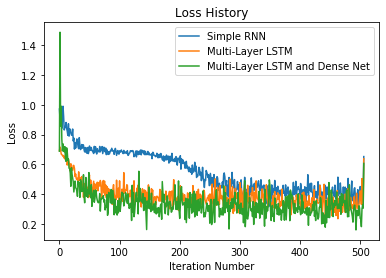

In [0]:
plt.figure()

plt.plot(range(len(loss_history_rnn)), loss_history_rnn, label='Simple RNN');
plt.plot(range(len(loss_history_lstm)), loss_history_lstm, label='Multi-Layer LSTM');
plt.plot(range(len(loss_history_lstm_dense)), loss_history_lstm_dense, 
         label='Multi-Layer LSTM and Dense Net');

plt.xlabel('Iteration Number');
plt.ylabel('Loss')
plt.title('Loss History');
plt.legend(loc='upper right');

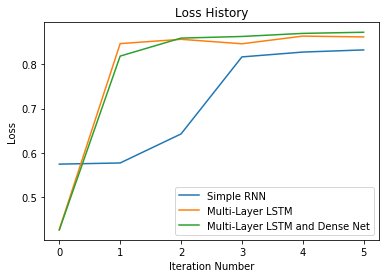

In [0]:
plt.figure()

plt.plot(range(len(perf_history_rnn)), perf_history_rnn, label='Simple RNN');
plt.plot(range(len(perf_history_lstm)), perf_history_lstm, label='Multi-Layer LSTM');
plt.plot(range(len(perf_history_lstm_dense)), perf_history_lstm_dense, 
         label='Multi-Layer LSTM and Dense Net');

plt.xlabel('Iteration Number');
plt.ylabel('Loss')
plt.title('Loss History');
plt.legend(loc='lower right');